# Import libraies

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

2024-02-02 21:09:37.057829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 21:09:37.057956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 21:09:37.216599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.config.list_physical_devices('GPU')) # checking tensorflow gpu is enabled or not for faster computation. (Optional)
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2.15.0


In [3]:
img_array = cv2.imread("/kaggle/input/face-mini-dataset/dataset/train/0/Training_345125.jpg")

In [4]:
img_array.shape

(48, 48, 3)

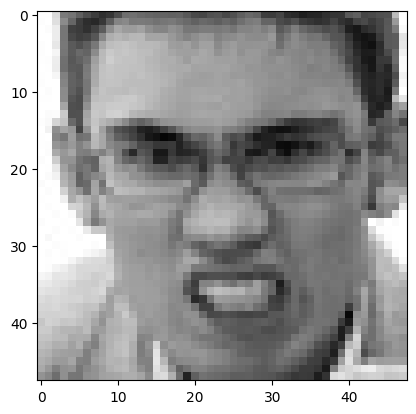

In [5]:
plt.imshow(img_array)

In [14]:
data_directory = "/kaggle/input/face-mini-dataset/dataset/train" # training datasets

In [15]:
classes = ["0","1","2","3","4","5","6"] # list of classes

# data generator

In [16]:
# in our training data folder "1" has only 436 images, but others have more. It will effect the training model. So will generate data from that.
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [17]:
# Add 11 images names to a list from 1 folder
imagesgen = ["Training_5420780.jpg","Training_5387344.jpg","Training_11050021.jpg","Training_13740441.jpg","Training_19204784.jpg","Training_25421729.jpg","Training_35175107.jpg","Training_41001987.jpg","Training_47680332.jpg","Training_62600200.jpg","Training_73540712.jpg"]

In [20]:
# create a folder named genPics1
try:
    directory = "/kaggle/input/face-mini-dataset/dataset/train/genPic1"
    path_dir = os.path.join(data_directory,directory)
    os.mkdir(path_dir)
except Exception as e:
    print(e)

[Errno 17] File exists: '/kaggle/input/face-mini-dataset/dataset/train/genPic1'


In [21]:
def imagesgenarator(img_list):
    for i in range(len(img_list)):
        pic = load_img(data_directory+"/1/"+img_list[i])
        pic_array = img_to_array(pic)
        pic_array = pic_array.reshape((1,) + pic_array.shape) # Converting into 4 dimension array
        # Generate 11 images
        # batch_size: At a time, how many image should be created.
        count = 0
        for batch in datagen.flow(pic_array, batch_size=5,save_to_dir=data_directory+"/genPic1", save_prefix=f'training{i}', save_format='jpeg'):
            count += 1
            if count > 95:
                break

In [22]:
imagesgenarator(imagesgen)

OSError: [Errno 30] Read-only file system: '/kaggle/input/face-mini-dataset/dataset/train/genPic1/training0_0_3895.jpeg'

In [24]:
# Moved images from genPic1 to 1 folder
target_fol = r"/kaggle/input/face-mini-dataset/dataset/train\1" + "\\"
source_fol = r"/kaggle/input/face-mini-dataset/dataset/train\genPic1" + "\\"
def move_files(source_fol,target_fol):
    try:
        for path, dir, files in os.walk(source_fol):
            for file in files:
                if not os.path.isfile(target_fol + file):
                    os.rename(path + '\\'+ file,target_fol+file)
        print("All files are moved")
    except Exception as e:
        print(e)                


In [25]:
move_files(source_fol,target_fol)

All files are moved


In [26]:
# Removed empty directory
try:
    os.rmdir(source_fol)
except Exception as e:
    print(e)    

[Errno 30] Read-only file system: '/kaggle/input/face-mini-dataset/dataset/train\\genPic1\\'


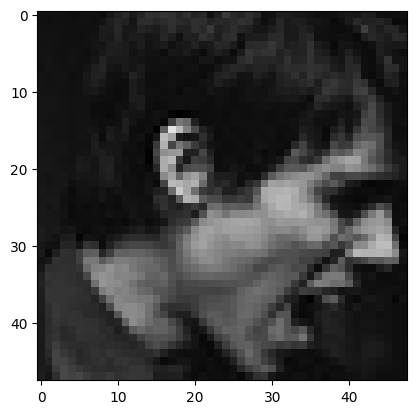

In [27]:
for catagory in classes:
    path = os.path.join(data_directory,catagory)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

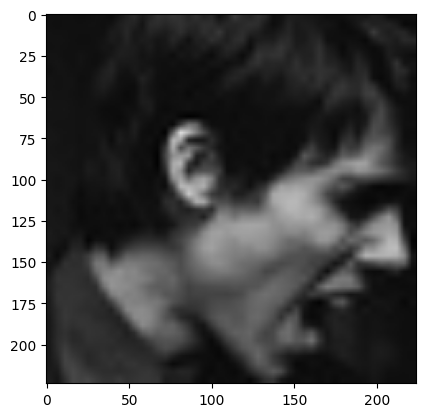

In [28]:
img_size = (224,224) # ImageNet 224 x 224
new_img_array = cv2.resize(img_array,img_size)
plt.imshow(cv2.cvtColor(new_img_array,cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
new_img_array.shape

(224, 224, 3)

In [30]:
# read all the images and convert them into array
training_data = [] # data array
def create_training_data():
    for catagory in classes:
        path = os.path.join(data_directory,catagory)
        class_num = classes.index(catagory)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_img_array = cv2.resize(img_array,img_size)
                training_data.append([new_img_array,class_num])
            except Exception as e:
                print(f"...{e}")    

        

In [31]:
create_training_data()

In [32]:
print(len(training_data))

7250


In [33]:
import random
random.shuffle(training_data)

In [34]:
X = [] # features
y = [] # label

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,img_size[0],img_size[1],3)   ## convert it to 4 dimenion for mobilenetv2

In [35]:
X.shape

(7250, 224, 224, 3)

In [36]:
# Normalizing the data
X = X / 255.0

In [37]:
y = np.array(y)

In [38]:
y.shape

(7250,)

# Deep learning model for training - Transfer learning

In [39]:
model = tf.keras.applications.MobileNetV2() # pre-trained model


14536120/14536120 [==============================] - 0s 0us/step


In [40]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

# Transfer Learning

### Tuning , weights will start from last check point

In [41]:
base_input = model.layers[0].input

In [42]:
base_output = model.layers[-2].output

In [43]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [44]:
# Adding layers
final_output = layers.Dense(128)(base_output) # Adding layer after the output of thr global pooling layer
final_output = layers.Activation('relu')(final_output) # Activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7,activation='softmax')(final_output) # Output classes are 7

In [45]:
final_output # output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [46]:
new_model = keras.Model(inputs=base_input,outputs= final_output)

In [47]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [48]:
new_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [49]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [50]:
new_model.fit(X,y,epochs=15, batch_size=32)

Epoch 1/15


I0000 00:00:1706908829.082451     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 61s 133ms/step - loss: 1.1772 - accuracy: 0.5479
Epoch 2/15
227/227 [==============================] - 28s 124ms/step - loss: 0.9608 - accuracy: 0.6366
Epoch 3/15
227/227 [==============================] - 29s 128ms/step - loss: 0.8831 - accuracy: 0.6655
Epoch 4/15
227/227 [==============================] - 29s 128ms/step - loss: 0.8046 - accuracy: 0.6979
Epoch 5/15
227/227 [==============================] - 29s 127ms/step - loss: 0.7368 - accuracy: 0.7240
Epoch 6/15
227/227 [==============================] - 29s 128ms/step - loss: 0.6874 - accuracy: 0.7447
Epoch 7/15
227/227 [==============================] - 29s 127ms/step - loss: 0.6323 - accuracy: 0.7665
Epoch 8/15
227/227 [==============================] - 29s 127ms/step - loss: 0.5807 - accuracy: 0.7851
Epoch 9/15
227/227 [==============================] - 29s 127ms/step - loss: 0.5468 - accuracy: 0.7999
Epoch 10/15
227/227 [==============================] - 29s 127ms/step - loss: 0.4863

In [52]:
new_model.save('face_emotion_rec_v2.keras')

In [41]:
# new_model = tf.keras.models.load_model("face_emotion_rec_v2.h5")

In [81]:
frame = cv2.imread("/kaggle/input/face-data-set/smiley_girl.jpg")

In [82]:
frame.shape

(1092, 1200, 3)

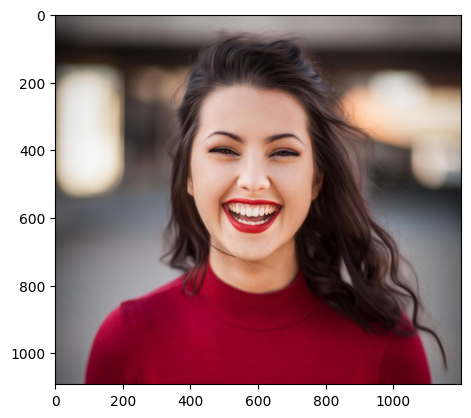

In [83]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [84]:
# Convert it into gray image and use face detection algorithm to detect face

face_detect = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

gray_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
gray_img.shape

(1092, 1200)

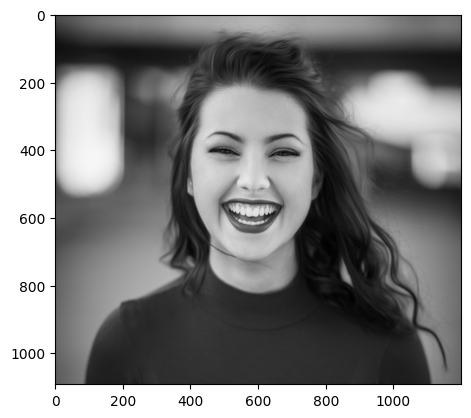

In [85]:
plt.imshow(cv2.cvtColor(gray_img,cv2.COLOR_BGR2RGB))

In [86]:
faces = face_detect.detectMultiScale(gray_img,1.1,4)
for x,y,w,h in faces:
    roi_gray_img = gray_img[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    facess = face_detect.detectMultiScale(roi_gray_img)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh,ex:ex +ew]    

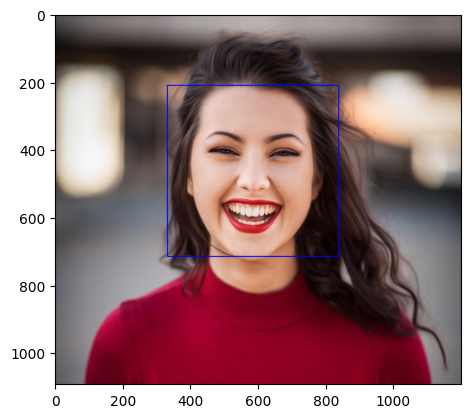

In [87]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

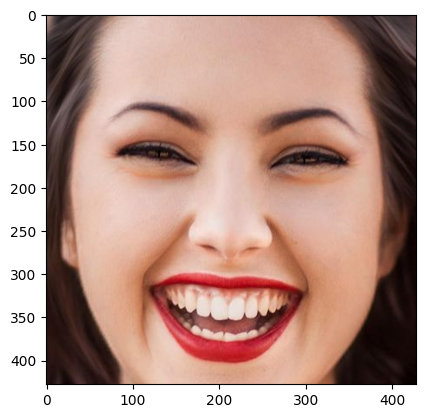

In [88]:
# cropped image
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [89]:
final_img = cv2.resize(face_roi,(224,224))
final_img = np.expand_dims(final_img,axis=0) # need 4th dimension
final_img = final_img/255 # normalizing

In [90]:
prediction = new_model.predict(final_img)
pred = np.argmax(prediction[0])
pred

1/1 [==============================] - 0s 24ms/step


4

In [91]:
classNames= []
classFile = '/kaggle/input/face-data-set/label.names'
with open(classFile,'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')

In [92]:
classNames[pred]

'Neutral'

# Make a predict  function

1/1 [==============================] - 1s 786ms/step
Surprise


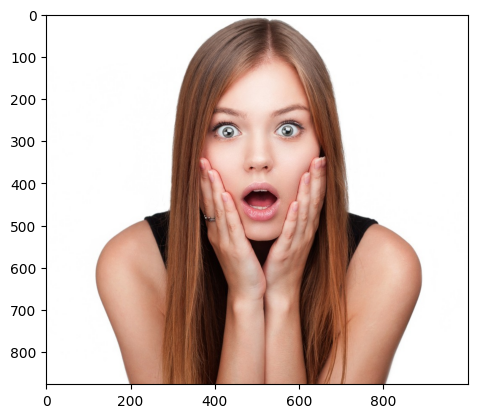

In [102]:

def prediction_img(img,detect_model,classNames,draw=True):
    frame = cv2.imread(img)
    if draw:
        plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    face_detect = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    gray_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_detect.detectMultiScale(gray_img,1.1,4)
    for x,y,w,h in faces:
        roi_gray_img = gray_img[y:y+h,x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        facess = face_detect.detectMultiScale(roi_gray_img)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey: ey+eh,ex:ex +ew]    
    
    final_img = cv2.resize(face_roi,(224,224))
    final_img = np.expand_dims(final_img,axis=0) # need 4th dimension
    final_img = final_img/255 # normalizing

    prediction = detect_model.predict(final_img)
    pred = np.argmax(prediction[0])

    return classNames[pred]

if __name__ =="__main__":
    classNames= []
    classFile = '/kaggle/input/face-data-set/label.names'
    with open(classFile,'rt') as f:
        classNames = f.read().rstrip('\n').split('\n')    

    detect_model = tf.keras.models.load_model("/kaggle/working/face_emotion_rec_v2.keras")    
    img = "/kaggle/input/face-data-set/surprise_girl.jpg"
    print(prediction_img(img,detect_model,classNames,draw=True))   